#Projet 1 : Bayesian integration in force estimation
Authors : Simon Vandergooten and Clémence Vandamme.

In this first project you will have the opportunity to practice what you learned during the exercice sessions. More precisely, you will see how the Bayesian integration can be used in the specific case of force estimation. 


##Guidelines : 

1) Read the paper "*Bayesian integration in force estimation*" by K. Körding (2004), available on Moodle in the section "Project".

2) Download the datasets **F_true**, **F_pert** and **delta_y** available on Moodle and store them in the folder of your choice.

3) Run the provided cells (Section 1) to import the datasets in Colab.

4) Perform the same data analysis as the paper to reproduce **Figures 1D & 2(A $\rightarrow$ F)** and discuss your results.

5) Answer the following questions to check your understanding of the article.

* Why is prior knowledge important in general ? How does it help (or not) reducing the errors in this task ? 

* What is the research question and why is the task suitable to answer it ? 

* Explain with your own words how each graphs of figure 2A are obtained. In particular, explain why we expect a linear relationship between dF and F_true if we use full bayesian strategies ? What does the slope represent ? 


For this project, no report is needed. You will simply drop on moodle one notebook per group. This notebook will contain your entire code (we should be able to generate your figures by running the notebook), the figures, some comments on your methods and the answer of the open questions. The due date is the **28th of October at 23:59**. 

We will then review together your notebook during a small discussion (10 minutes). You will have the opportunity to explain us in more details what you have done. During this talk, we will also ask you some basic questions to check your understanding of the project. This is not a formal presentation, but it is mandatory.  



##Some indications

First, recall that the Bayes theorem states: 

$$Posterior \propto prior * likelihood$$

###About the data: 

After the article reading, take a moment to explore the data structure. The data you have access to are stored in a dictionary `Dict`. In this dictionary, you can then access all subjects (the first 6 subjects belong to group 1, the 5 last belong to group 2). Each subjects entry contains 3 numpy arrays: `F_true`, `F_pert` and `delta_y`. Those arrays are of size (3, 1400). Each line correspond to a day and is composed of the 7 blocks of 200 trials placed consecutively. 

Example: You can access the values of the perturbation force for the second subject with `Dict['Sujet 2']['F_pert']`. This will return an numpy array. 

*Click [here](https://docs.python.org/3/tutorial/datastructures.html) for more context about dictionary (See section 5.5)*.

* `F_true` is the true force the subjects experienced during the first pulse of a trial. As in the paper, it is drawn from two gaussian distributions that differ in their variance. Out of the 11 subjects, the first six experienced the wide distribution for the first two days then the narrow distribution during day 3. It is the opposite for the last five subjects.

* `F_pert` is a small perturbation added to the second pulse. It is also gaussian distributed. 

* `delta_y` is the positional error subjects made with respect to the target. 

* You can use $c = 0.68 [\frac{N}{cm}]$

Note that these data are not the experimental results of the article. Those are artificial data simulated by us, as we do not have access to the original dataset. Therefore, you will not recover the exact same graphs as the article, but you should obtain similar ones. 



#Section 1: Import datasets 


In [2]:
#import libraries
import numpy as np
import pandas as pd 
import io
import matplotlib.pyplot as plt
from pprint import pprint
from matplotlib import pyplot as plt
from IPython.display import Markdown, display, Image
from sklearn.linear_model import LinearRegression
def printmd(string):
    display(Markdown(string))
%matplotlib inline

In [3]:
# @title Run then select the files F_true.csv, F_pert.csv and delta_y.csv on your computer
from google.colab import files
uploaded = files.upload()

Saving delta_y.csv to delta_y.csv
Saving F_pert.csv to F_pert.csv
Saving F_true.csv to F_true.csv


In [4]:
# @title Run to access and store the datasets
F_true = pd.read_csv(io.BytesIO(uploaded['F_true.csv'])).to_numpy()[:,1:]
F_pert = pd.read_csv(io.BytesIO(uploaded['F_pert.csv'])).to_numpy()[:,1:]
delta_y = pd.read_csv(io.BytesIO(uploaded['delta_y.csv'])).to_numpy()[:,1:]

n_subjects = 11
n_days = 3
Dict = {}

for subject in range(n_subjects):
  Dict['Sujet ' + str(subject + 1)] = {'F_true':F_true[subject * n_days:(subject + 1) * n_days,:], 'F_pert':F_pert[subject * n_days:(subject + 1) * n_days,:], 'delta_y':delta_y[subject * n_days:(subject + 1) * n_days,:]}



You have now access to the dictionary **Dict**.




#Section 2: Your results

**Graph 1D : Influence of the Fpert on the endpoint error Delta y for 1 subject experiencing the narrow distribution** 


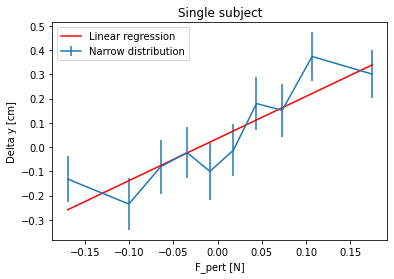

In [5]:
printmd('**Graph 1D : Influence of the Fpert on the endpoint error Delta y for 1 subject experiencing the narrow distribution** \n')
#In the legends of the graphs, narrow distribution means subjects that that started with a narrow distribution (0.5N) and wide distribution is for subjects that started with a wide distribution (1N)

"parameters"
c = 0.68 #N/cm^3 proportionality constant 

"Extraction of the data out of the library for the first subject with narrow distribution"
pert1 = Dict['Sujet 7']['F_pert']                   #extraction of the data of F_pert for subject 7
deltay1 = Dict['Sujet 7']['delta_y']                #extraction of the data of delta_y for subject 7
deltay1ok = deltay1[0]                              #extraction of the data only for the first day(=first line)

"data manipulation: the aim is to obtain F_pert in ascending order (for the x axis) and then sort the corrsponding delta_y values in the same order"
sortpert1 = np.argsort(pert1[0])                    #returns the indexes for the values of F_pert in ascending order 
deltayoksort = np.zeros(len(deltay1ok))             #creates an empty array for deltayoksort to sort it the same way as F_pert

for i in range(len(deltay1ok)):                     #loop to fill the array for delta_y
  deltayoksort[i] = deltay1ok[sortpert1[i]]         #fills the array with the values of delta_y sorted according to F_pert

"To trace the graph, the data will be splitted into 10 intervals to average the errors" 
splitsdeltay1 = np.array_split(deltayoksort, 10)    #splits the sorted delta_y array into 10 intervals with the same number of data
deltay_split_avg = [np.mean(arr) for arr in splitsdeltay1] #creates an array containing the 10 mean values for the delta_y of each interval

"Splitting of the F_pert data in 10 intervals"
sortpert11 = np.sort(pert1[0])                      #classification of the F_pert values by ascending order
splitssortpert = np.array_split(sortpert11, 10)     #splits the sorted F_pert array into 10 intervals with the same number of data
fpertsort_split_avg = [np.mean(arr) for arr in splitssortpert] #creates an array containing the 10 mean values for the F_pert of each interval

"Computation of the standard deviations to plot the error bars"
sddeviationy = [np.std(arr) for arr in splitsdeltay1]/np.sqrt(len(deltay1ok)/10) #creates an array containing the standard deviations of delta_y for each interval

"Linear regression"
model = LinearRegression().fit(np.array(fpertsort_split_avg).reshape(-1,1), np.array(deltay_split_avg).reshape(-1,1)) #computes the linear regression
y_pred = model.predict(np.array(fpertsort_split_avg).reshape(-1,1))

"Graph plot"
plt.title("Single subject")
plt.xlabel('F_pert [N]')
plt.ylabel('Delta y [cm]')
plt.errorbar(fpertsort_split_avg, deltay_split_avg, yerr = sddeviationy, label='Narrow distribution')
plt.plot(np.array(fpertsort_split_avg).reshape(-1,1), y_pred, label='Linear regression', color='red')
plt.legend()
plt.show()

**Graph 1D: Influence of the F_pert on the endpoint error Delta y for all subjects** 


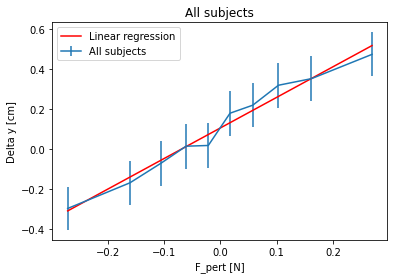

In [6]:
printmd('**Graph 1D: Influence of the F_pert on the endpoint error Delta y for all subjects** \n')


"Data extraction"
#The dictionary has a length of 11, which corresponds to the number of subjects. The keys correspond to the subjects while the data values are stocked in arrays F_y, F_pert et delta_y.
#To manipulate the data of the dictionary, we extracted the data and stored them into separate matrices.

matrice_Y =  np.zeros(shape=(11, len(deltay1ok)))             #creation of a matrix for the storage of delta_y values for each subjects (one subject=one line)
matrice_F =  np.zeros(shape=(11, len(deltay1ok)))             #creation of a matrix for the storage of F_pert values for each subjects (one subject=one line)

Sujet = ['Sujet 1', 'Sujet 2' , 'Sujet 3', 'Sujet 4', 'Sujet 5', 'Sujet 6' , 'Sujet 7', 'Sujet 8', 'Sujet 9', 'Sujet 10' , 'Sujet 11'] #creation of a vector resuming all the subjects to be able to call them

 
#Filling of the matrixes with the data etracted from the dictionary

i = 0
for s in Sujet:
  matrice_F[i] = Dict[s]['F_pert'][0]                         #Fills the matrix with the data of F_pert for all the subjects, each line corresponds to a subject (matrix 11x1400)
  i = i+1

j =0 
for su in Sujet:
  matrice_Y[j] = Dict[su]['delta_y'][0]                       #Fills the matrix with the data of delta_y for all the subjects, each line corresponds to a subject
  j = j+1


"Data manipulation: the aim is to obtain F_pert in ascending order (for the x axis) and then sort the corrsponding delta_y values in the same order"
#We have to sort the data the same way as for the previous graph: sort F_pert and the corresponding delta_y. 

matrice_F_argsort = np.argsort(matrice_F, axis=1)             #returns the indexes of F_pert by ascending values for each line and thus each subject 
matrice_F_sort = np.sort(matrice_F, axis = 1)                 #sort the F_pert data by ascending order to be able to make 10 intervals later


deltayall_sort = np.zeros(shape=(11, len(deltay1ok)))         #creation of a matrix 11x1400 to fill the corresponding delta_y data in the same order as F_pert
for k in range(11):                                           #loop to sort each line of data in the same way as F_pert 
  deltayall_sort[k] = matrice_Y[k][matrice_F_argsort[k]]      #sorts and fills the matrix of delta_y given F_pert


"Splitting of the matrixes in 10 intervals"
deltay_split_avgall = np.zeros(10)                            #creates an array of zise 10 to store the mean values of delta_y for the whole matrix divided in 10 intervals
for l in range(11):
  splitsdeltayall = np.array_split(deltayall_sort[l], 10)     #splits each line of the matrix in 10 equal intervals 
  deltay_split_avgall += np.array([np.mean(arr) for arr in splitsdeltayall]) #fills the array with the means of delta_y of each interval for each line(=each subject) of the matrix
deltay_splitallfini = deltay_split_avgall/11                  #split in 11 because sum over 11 subjects

 
Fpert_split_avgall=np.zeros(10)                               #same methodoly to split the F_pert matrix 
for m in range(11):
  splitsFpertall = np.array_split(matrice_F_sort[m], 10) 
  Fpert_split_avgall += np.array([np.mean(arr) for arr in splitsFpertall]) 
Fpert_splitallfini = Fpert_split_avgall/11


"Computation of the standard deviations to plot the error bars"
sddeviation_deltayall=np.zeros(10) 
for m in range(11):
  splitsdeltayall = np.array_split(deltayall_sort[m], 10)
  sddeviation_deltayall += np.array([np.std(arr) for arr in splitsdeltayall]/np.sqrt(len(deltay1ok)/10)) #creates an array containing the standard deviations of F_pert for each interval
std_dev_deltayall = sddeviation_deltayall/11

"Linear regression"
model1 = LinearRegression().fit(np.array(Fpert_splitallfini).reshape(-1,1), np.array(deltay_splitallfini).reshape(-1,1)) #computes the linear regression
y_pred = model1.predict(np.array(Fpert_splitallfini).reshape(-1,1))


"Graph plot"
plt.title("All subjects")
plt.xlabel('F_pert [N]')
plt.ylabel('Delta y [cm]')
plt.errorbar(Fpert_splitallfini, deltay_splitallfini, yerr = std_dev_deltayall, label='All subjects')
plt.plot(np.array(Fpert_splitallfini).reshape(-1,1), y_pred, color='red', label='Linear regression')
plt.legend()
plt.show()



**Graph 2C: Average force estimation error plotted against true force for the population of subjects** 


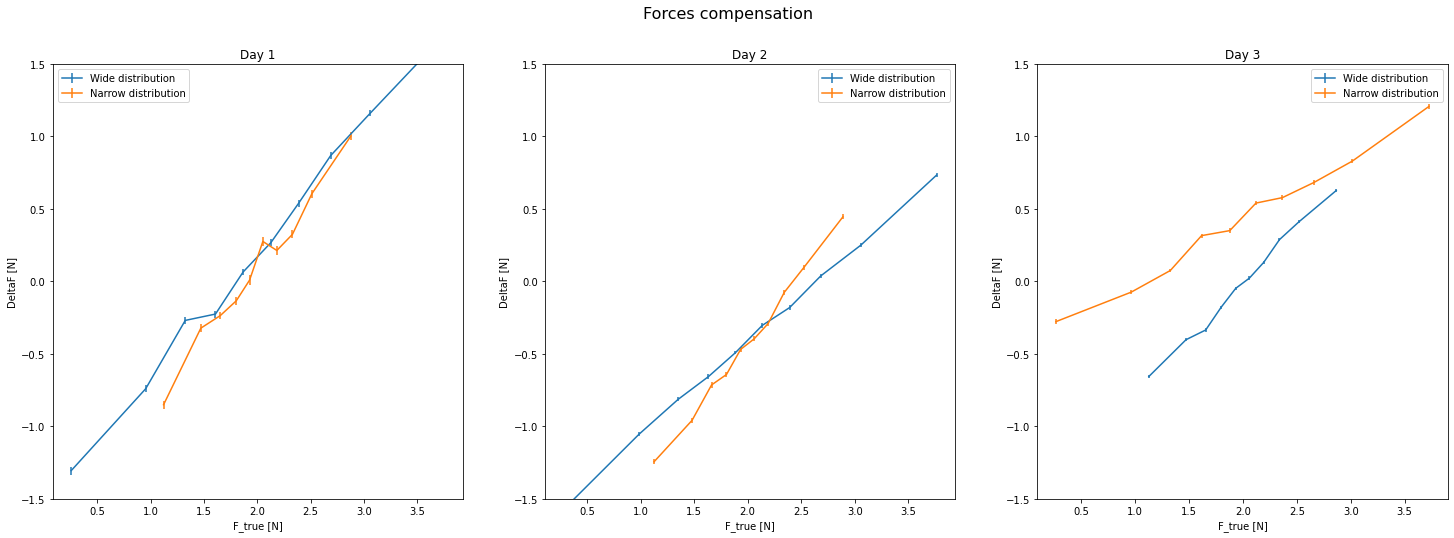

In [10]:
printmd('**Graph 2C: Average force estimation error plotted against true force for the population of subjects** \n')


"Data extraction"
#To be able to manipulate the data easily, we create matrixes containing the data for Group 1 and Group 2 independently. 
Group1 = ['Sujet 1', 'Sujet 2' , 'Sujet 3', 'Sujet 4', 'Sujet 5', 'Sujet 6'] #creation of a vector resuming all the subjects of group 1 to be able to call them
Group2 = ['Sujet 7', 'Sujet 8', 'Sujet 9', 'Sujet 10' , 'Sujet 11']   #creation of a vector resuming all the subjects of group 2 to be able to call them

 
"data extraction: day 1 - group 1"
matrice_Y1 =  np.zeros(shape=(6, len(deltay1ok)))                     #creation of a matrix 6x1400 for the data of delta_y for the first group (6 first subjects). One line corresponds to the data of one subject.
matrice_F1 =  np.zeros(shape=(6, len(deltay1ok)))                     #creation of a matrix 6x1400 for the data of F_pert for the first group (6 first subjects). One line corresponds to the data of one subject.
matrice_Ftrue1 =  np.zeros(shape=(6, len(deltay1ok)))                 #creation of a matrix 6x1400 for the data of F_true for the first group (6 first subjects). One line corresponds to the data of one subject.


#Filling of the matrixes with the data extracted from the dictionary
n = 0
for s in Group1 :
  matrice_F1[n] = Dict[s]['F_pert'][0]                                #Fills the matrix with the data of F_pert for all the subjects of group 1, each line corresponds to a subject (matrix 6x1400)
  n = n+1

p = 0
for s in Group1 :
  matrice_Y1[p] = Dict[s]['delta_y'][0]                               #Fills the matrix with the data of delta_y for all the subjects of group 1, each line corresponds to a subject 
  p = p+1

q = 0
for s in Group1 :
  matrice_Ftrue1[q] = Dict[s]['F_true'][0]                            #Fills the matrix with the data of F_true for all the subjects of group 1, each line corresponds to a subject (matrix 11x1400)
  q = q+1



"data extraction: day 1 - group 2"
matrice_Y2 =  np.zeros(shape=(5, len(deltay1ok)))                     #creation of a matrix 5x1400 for the data of delta_y for the second group (5 last subjects). One line corresponds to the data of one subject.
matrice_F2 =  np.zeros(shape=(5, len(deltay1ok)))                     #creation of a matrix 5x1400 for the data of F_pert for the second group (5 last subjects). One line corresponds to the data of one subject.
matrice_Ftrue2 =  np.zeros(shape=(5, len(deltay1ok)))                 #creation of a matrix 5x1400 for the data of F_true for the second group (5 last subjects). One line corresponds to the data of one subject.


#Filling of the matrixes with the data extracted from the dictionary (same operations as for group 1)
r = 0
for s in Group2 :
  matrice_F2[r] = Dict[s]['F_pert'][0] 
  r = r+1

t = 0
for s in Group2 :
  matrice_Y2[t] = Dict[s]['delta_y'][0] 
  t = t+1

u = 0
for s in Group2 :
  matrice_Ftrue2[u] = Dict[s]['F_true'][0] 
  u = u+1



"data extraction: day2 - group 1"
#creation of matrixes - same operations as for day 1 
matrice_Y12 = np.zeros(shape=(6, len(deltay1ok))) 
matrice_F12 = np.zeros(shape=(6, len(deltay1ok)))
matrice_Ftrue12 = np.zeros(shape=(6, len(deltay1ok)))


#Filling of the matrixes with the data extracted from the dictionary - same operations as for day 1
n1 = 0
for s in Group1 :
  matrice_F12[n1] = Dict[s]['F_pert'][1] 
  n1 = n1+1

p1 = 0
for s in Group1 :
  matrice_Y12[p1] = Dict[s]['delta_y'][1] 
  p1 = p1+1 

q1 = 0
for s in Group1 :
  matrice_Ftrue12[q1] = Dict[s]['F_true'][1] 
  q1 = q1+1



"data extraction: day 2 - group 2"
#creation of matrixes - same operations as for day 1 
matrice_Y22 = np.zeros(shape=(5, len(deltay1ok))) 
matrice_F22 = np.zeros(shape=(5, len(deltay1ok))) 
matrice_Ftrue22 =  np.zeros(shape=(5, len(deltay1ok))) 

 
#Filling of the matrixes with the data extracted from the dictionary - same operations as for day 1
r1 = 0
for s in Group2 :
  matrice_F22[r1] = Dict[s]['F_pert'][1] 
  r1 = r1+1

t1 = 0
for s in Group2 :
  matrice_Y22[t1] = Dict[s]['delta_y'][1] 
  t1 = t1+1

u1 = 0
for s in Group2 :
  matrice_Ftrue22[u1] = Dict[s]['F_true'][1] 
  u1 = u1+1



"data extraction: day 3 - group 1"
#creation of matrixes to store the data - same operations as previously 
matrice_Y13 =  np.zeros(shape=(6, len(deltay1ok)))
matrice_F13 =  np.zeros(shape=(6, len(deltay1ok))) 
matrice_Ftrue13 =  np.zeros(shape=(6, len(deltay1ok)))


#Filling of the matrixes with the data extracted from the dictionary - same operations as previously
n2 = 0
for s in Group1 :
  matrice_F13[n2] = Dict[s]['F_pert'][2] 
  n2 = n2+1

p2 = 0
for s in Group1 :
  matrice_Y13[p2] = Dict[s]['delta_y'][2] 
  p2 = p2+1

q2 = 0
for s in Group1 :
  matrice_Ftrue13[q2] = Dict[s]['F_true'][2] 
  q2 = q2+1



"data extraction: day 3 - group 2"
#creation of matrixes to store the data - same operations as previously 
matrice_Y23 =  np.zeros(shape=(5, len(deltay1ok)))
matrice_F23 =  np.zeros(shape=(5, len(deltay1ok))) 
matrice_Ftrue23 =  np.zeros(shape=(5, len(deltay1ok))) 


#Filling of the matrixes with the data extracted from the dictionary - same operations as previously
r2 = 0
for s in Group2 :
  matrice_F23[r2] = Dict[s]['F_pert'][2] 
  r2 = r2+1 

t2 = 0
for s in Group2 :
  matrice_Y23[t2] = Dict[s]['delta_y'][2] 
  t2 = t2+1

u2 = 0
for s in Group2 :
  matrice_Ftrue23[u2] = Dict[s]['F_true'][2] 
  u2 = u2+1




"Data manipulation: sort the data and split it into intervals for which the mean is computed" 

"data manipulation: Day 1 - group 1"
matrice_Ftrue1_argsort = np.argsort(matrice_Ftrue1, axis=1)   #returns the indexes of F_true by ascending values for each line and thus each subject 
matrice_Ftrue1_sort = np.sort(matrice_Ftrue1, axis = 1)       #sorts the F_true values by ascending order

matrice_Y1sort = np.zeros(shape=(6, len(deltay1ok)))          #creation of a matrix to sort the delta_y data
matrice_F1sort = np.zeros(shape=(6, len(deltay1ok)))          #creation of a matrix to sort the F_pert data

 
for k in range(6):                                            #loop to fill the matrixes with the corresponding data depending on the indexes of the sorted F_true arrays
  matrice_Y1sort[k] = matrice_Y1[k][matrice_Ftrue1_argsort[k]] 
  matrice_F1sort[k] = matrice_F1[k][matrice_Ftrue1_argsort[k]]


matrice_Ftrue1_split_avgall = np.zeros(10)
for l in range(6):
  splitsFtrue1 = np.array_split(matrice_Ftrue1_sort[l], 10)   #splits the F_true arrays into 10 equal intervals
  matrice_Ftrue1_split_avgall += np.array([np.mean(arr) for arr in splitsFtrue1]) #computes the means of each interval and sums the means of the corresponding intervals of the matrix
matrice_Ftrue1fini = matrice_Ftrue1_split_avgall/6            #division by 6 because sum of means over 6 subjects

 
matrice_F1_split_avgall = np.zeros(10)
for l in range(6):
  splitsF1 = np.array_split(matrice_F1sort[l], 10)            #splits the F_pert arrays into 10 equal intervals
  matrice_F1_split_avgall += np.array([np.mean(arr) for arr in splitsF1]) #computes the means of each interval and sums the means of the corresponding intervals of the matrix
matrice_F1fini = matrice_F1_split_avgall/6                    #division by 6 because sum of means over 6 subjects

 
matrice_Y1_split_avgall = np.zeros(10)
for l in range(6):
  splitsY1 = np.array_split(matrice_Y1sort[l], 10)            #splits the F_pert arrays into 10 equal intervals
  matrice_Y1_split_avgall += np.array([np.mean(arr) for arr in splitsY1]) #computes the means of each interval and sums the means of the corresponding intervals of the matrix
matrice_Y1fini = matrice_Y1_split_avgall/6                    #division by 6 because sum of means over 6 subjects



"Data manipulation: Day 1 - group 2" 
#all the operations are the same as for group 1 exept the used data
matrice_Ftrue2_argsort = np.argsort(matrice_Ftrue2, axis=1) 
matrice_Ftrue2_sort = np.sort(matrice_Ftrue2, axis = 1) 

matrice_Y2sort = np.zeros(shape=(5, len(deltay1ok))) 
matrice_F2sort = np.zeros(shape=(5, len(deltay1ok)))

 
for k in range(5):
  matrice_Y2sort[k] = matrice_Y2[k][matrice_Ftrue2_argsort[k]] 
  matrice_F2sort[k] = matrice_F2[k][matrice_Ftrue2_argsort[k]]

 
matrice_Ftrue2_split_avgall = np.zeros(10)
for l in range(5):
  splitsFtrue2 = np.array_split(matrice_Ftrue2_sort[l], 10) 
  matrice_Ftrue2_split_avgall += np.array([np.mean(arr) for arr in splitsFtrue2]) 
matrice_Ftrue2fini = matrice_Ftrue2_split_avgall/5 

 
matrice_F2_split_avgall = np.zeros(10)
for l in range(5):
  splitsF2 = np.array_split(matrice_F2sort[l], 10)
  matrice_F2_split_avgall += np.array([np.mean(arr) for arr in splitsF2]) 
matrice_F2fini = matrice_F2_split_avgall/5 

 
matrice_Y2_split_avgall = np.zeros(10)
for l in range(5):
  splitsY2 = np.array_split(matrice_Y2sort[l], 10) 
  matrice_Y2_split_avgall += np.array([np.mean(arr) for arr in splitsY2]) 
matrice_Y2fini = matrice_Y2_split_avgall/5 



"Data manipulation: Day 2 - group 1" 
#all the operations are the same as previously
matrice_Ftrue12_argsort = np.argsort(matrice_Ftrue12, axis=1) 
matrice_Ftrue12_sort = np.sort(matrice_Ftrue12, axis = 1) 

matrice_Y12sort = np.zeros(shape=(6, len(deltay1ok))) 
matrice_F12sort = np.zeros(shape=(6, len(deltay1ok)))

 
for k in range(6):
  matrice_Y12sort[k] = matrice_Y12[k][matrice_Ftrue12_argsort[k]] 
  matrice_F12sort[k] = matrice_F12[k][matrice_Ftrue12_argsort[k]]

 
matrice_Ftrue12_split_avgall = np.zeros(10)
for l in range(6):
  splitsFtrue12 = np.array_split(matrice_Ftrue12_sort[l], 10) 
  matrice_Ftrue12_split_avgall += np.array([np.mean(arr) for arr in splitsFtrue12]) 
matrice_Ftrue12fini = matrice_Ftrue12_split_avgall/6 

 
matrice_F12_split_avgall = np.zeros(10)
for l in range(6):
  splitsF12 = np.array_split(matrice_F12sort[l], 10) 
  matrice_F12_split_avgall += np.array([np.mean(arr) for arr in splitsF12]) 
matrice_F12fini = matrice_F12_split_avgall/6 

 
matrice_Y12_split_avgall = np.zeros(10)
for l in range(6):
  splitsY12 = np.array_split(matrice_Y12sort[l], 10) 
  matrice_Y12_split_avgall += np.array([np.mean(arr) for arr in splitsY12]) 
matrice_Y12fini = matrice_Y12_split_avgall/6 



"Data manipulation: Day 2 - group 2" 
#all the operations are the same as previously
matrice_Ftrue22_argsort = np.argsort(matrice_Ftrue22, axis=1) 
matrice_Ftrue22_sort = np.sort(matrice_Ftrue22, axis = 1) 

matrice_Y22sort = np.zeros(shape=(5, len(deltay1ok))) 
matrice_F22sort = np.zeros(shape=(5, len(deltay1ok)))


for k in range(5):
  matrice_Y22sort[k] = matrice_Y22[k][matrice_Ftrue22_argsort[k]] 
  matrice_F22sort[k] = matrice_F22[k][matrice_Ftrue22_argsort[k]]


matrice_Ftrue22_split_avgall = np.zeros(10)
for l in range(5):
  splitsFtrue22 = np.array_split(matrice_Ftrue22_sort[l], 10) 
  matrice_Ftrue22_split_avgall += np.array([np.mean(arr) for arr in splitsFtrue22])
matrice_Ftrue22fini = matrice_Ftrue22_split_avgall/5 

 
matrice_F22_split_avgall = np.zeros(10)
for l in range(5):
  splitsF22 = np.array_split(matrice_F22sort[l], 10) 
  matrice_F22_split_avgall += np.array([np.mean(arr) for arr in splitsF22]) 
matrice_F22fini = matrice_F22_split_avgall/5 

 
matrice_Y22_split_avgall = np.zeros(10)
for l in range(5):
  splitsY22 = np.array_split(matrice_Y22sort[l], 10) 
  matrice_Y22_split_avgall += np.array([np.mean(arr) for arr in splitsY22]) 
matrice_Y22fini = matrice_Y22_split_avgall/5 



"Data manipulation: Day 3 - group 1" 
#all the operations are the same as previously
matrice_Ftrue13_argsort = np.argsort(matrice_Ftrue13, axis=1) 
matrice_Ftrue13_sort = np.sort(matrice_Ftrue13, axis = 1) 

matrice_Y13sort = np.zeros(shape=(6, len(deltay1ok))) 
matrice_F13sort = np.zeros(shape=(6, len(deltay1ok)))


for k in range(6):
  matrice_Y13sort[k] = matrice_Y13[k][matrice_Ftrue13_argsort[k]] 
  matrice_F13sort[k] = matrice_F13[k][matrice_Ftrue13_argsort[k]]


matrice_Ftrue13_split_avgall = np.zeros(10)
for l in range(6):
  splitsFtrue13 = np.array_split(matrice_Ftrue13_sort[l], 10) 
  matrice_Ftrue13_split_avgall += np.array([np.mean(arr) for arr in splitsFtrue13]) 
matrice_Ftrue13fini = matrice_Ftrue13_split_avgall/6 


matrice_F13_split_avgall = np.zeros(10)
for l in range(6):
  splitsF13 = np.array_split(matrice_F13sort[l], 10) 
  matrice_F13_split_avgall += np.array([np.mean(arr) for arr in splitsF13]) 
matrice_F13fini = matrice_F13_split_avgall/6

 
matrice_Y13_split_avgall = np.zeros(10)
for l in range(6):
  splitsY13 = np.array_split(matrice_Y13sort[l], 10) 
  matrice_Y13_split_avgall += np.array([np.mean(arr) for arr in splitsY13])
matrice_Y13fini = matrice_Y13_split_avgall/6



"Data manipulation: Day 3 - group 1" 
#all the operations are the same as previously
matrice_Ftrue23_argsort = np.argsort(matrice_Ftrue23, axis=1) 
matrice_Ftrue23_sort = np.sort(matrice_Ftrue23, axis = 1) 

matrice_Y23sort = np.zeros(shape=(5, len(deltay1ok))) 
matrice_F23sort = np.zeros(shape=(5, len(deltay1ok)))

 
for k in range(5):
  matrice_Y23sort[k] = matrice_Y23[k][matrice_Ftrue23_argsort[k]] 
  matrice_F23sort[k] = matrice_F23[k][matrice_Ftrue23_argsort[k]]


matrice_Ftrue23_split_avgall = np.zeros(10)
for l in range(5):
  splitsFtrue23 = np.array_split(matrice_Ftrue23_sort[l], 10) 
  matrice_Ftrue23_split_avgall += np.array([np.mean(arr) for arr in splitsFtrue23]) 
matrice_Ftrue23fini = matrice_Ftrue23_split_avgall/5 


matrice_F23_split_avgall = np.zeros(10)
for l in range(5):
  splitsF23 = np.array_split(matrice_F23sort[l], 10) 
  matrice_F23_split_avgall += np.array([np.mean(arr) for arr in splitsF23]) 
matrice_F23fini = matrice_F23_split_avgall/5

 
matrice_Y23_split_avgall = np.zeros(10)
for l in range(5):
  splitsY23 = np.array_split(matrice_Y23sort[l], 10) 
  matrice_Y23_split_avgall += np.array([np.mean(arr) for arr in splitsY23]) 
matrice_Y23fini = matrice_Y23_split_avgall/5




"Computation of the standard deviations to plot the error bars: Day 1"
#group 1
std_dev_Ftrue1fini=np.zeros(10)                  #creation of empty arrays to store the standard deviations of the 10 intervals 
std_dev_F1fini=np.zeros(10)
std_dev_Y1fini=np.zeros(10)


std_dev_Ftrue1fini += np.array([np.std(arr) for arr in splitsFtrue1]/np.sqrt(len(deltay1ok)/10)) #creates an array containing the standard deviations of F_true for each interval
std_dev_Ftrue1 = std_dev_Ftrue1fini/6

std_dev_F1fini += np.array([np.std(arr) for arr in splitsF1]/np.sqrt(len(deltay1ok)/10)) #creates an array containing the standard deviations of F_pert for each interval
std_dev_F1 = std_dev_F1fini/6

std_dev_Y1fini += np.array([np.std(arr) for arr in splitsY1]/np.sqrt(len(deltay1ok)/10)) #creates an array containing the standard deviations of delta_y for each interval
std_dev_Y1 = std_dev_Y1fini/6

std_dev_Fest10 = std_dev_Ftrue1 + std_dev_F1 - std_dev_Y1/c   #computation of the F_est standard deviation
std_dev_DeltaF10 = std_dev_Ftrue1 - std_dev_Fest10            #computation of the delta_F standard deviation


#group2
std_dev_Ftrue2fini=np.zeros(10)                   #creation of empty arrays to store the standard deviations of the 10 intervals
std_dev_F2fini=np.zeros(10)
std_dev_Y2fini=np.zeros(10) 


std_dev_Ftrue2fini += np.array([np.std(arr) for arr in splitsFtrue2]/np.sqrt(len(deltay1ok)/10)) #creates an array containing the standard deviations of F_true for each interval
std_dev_Ftrue2 = std_dev_Ftrue2fini/5

std_dev_F2fini += np.array([np.std(arr) for arr in splitsF2]/np.sqrt(len(deltay1ok)/10)) #creates an array containing the standard deviations of F_pert for each interval
std_dev_F2 = std_dev_F2fini/5

std_dev_Y2fini += np.array([np.std(arr) for arr in splitsY2]/np.sqrt(len(deltay1ok)/10)) #creates an array containing the standard deviations of delta_y for each interval
std_dev_Y2 = std_dev_Y2fini/5

std_dev_Fest20 = std_dev_Ftrue2 + std_dev_F2 - std_dev_Y2/c   #computation of the F_est standard deviation
std_dev_DeltaF20 = std_dev_Ftrue2 - std_dev_Fest20            #computation of the delta_F standard deviation




"Computation of the standard deviations to plot the error bars: Day 2"
#group 1
std_dev_Ftrue12fini=np.zeros(10)                  #creation of empty arrays to store the standard deviations of the 10 intervals 
std_dev_F12fini=np.zeros(10)
std_dev_Y12fini=np.zeros(10)


std_dev_Ftrue12fini += np.array([np.std(arr) for arr in splitsFtrue12]/np.sqrt(len(deltay1ok)/10)) #creates an array containing the standard deviations of F_true for each interval
std_dev_Ftrue12 = std_dev_Ftrue12fini/6

std_dev_F12fini += np.array([np.std(arr) for arr in splitsF12]/np.sqrt(len(deltay1ok)/10)) #creates an array containing the standard deviations of F_pert for each interval
std_dev_F12 = std_dev_F12fini/6

std_dev_Y12fini += np.array([np.std(arr) for arr in splitsY12]/np.sqrt(len(deltay1ok)/10)) #creates an array containing the standard deviations of delta_y for each interval
std_dev_Y12 = std_dev_Y12fini/6

std_dev_Fest102 = std_dev_Ftrue12 + std_dev_F12 - std_dev_Y12/c   #computation of the F_est standard deviation
std_dev_DeltaF102 = std_dev_Ftrue12 - std_dev_Fest102            #computation of the delta_F standard deviation


#group2
std_dev_Ftrue22fini=np.zeros(10)                    #creation of empty arrays to store the standard deviations of the 10 intervals
std_dev_F22fini=np.zeros(10)
std_dev_Y22fini=np.zeros(10) 

std_dev_Ftrue22fini += np.array([np.std(arr) for arr in splitsFtrue22]/np.sqrt(len(deltay1ok)/10)) #creates an array containing the standard deviations of F_true for each interval
std_dev_Ftrue22 = std_dev_Ftrue22fini/5

std_dev_F22fini += np.array([np.std(arr) for arr in splitsF22]/np.sqrt(len(deltay1ok)/10)) #creates an array containing the standard deviations of F_pert for each interval
std_dev_F22 = std_dev_F22fini/5

std_dev_Y22fini += np.array([np.std(arr) for arr in splitsY22]/np.sqrt(len(deltay1ok)/10)) #creates an array containing the standard deviations of delta_y for each interval
std_dev_Y22 = std_dev_Y22fini/5

std_dev_Fest202 = std_dev_Ftrue22 + std_dev_F22 - std_dev_Y22/c   #computation of the F_est standard deviation
std_dev_DeltaF202 = std_dev_Ftrue22 - std_dev_Fest202            #computation of the delta_F standard deviation




"Computation of the standard deviations to plot the error bars: Day 3"
#group 1
std_dev_Ftrue13fini=np.zeros(10)                  #creation of empty arrays to store the standard deviations of the 10 intervals 
std_dev_F13fini=np.zeros(10)
std_dev_Y13fini=np.zeros(10)


std_dev_Ftrue13fini += np.array([np.std(arr) for arr in splitsFtrue13]/np.sqrt(len(deltay1ok)/10)) #creates an array containing the standard deviations of F_true for each interval
std_dev_Ftrue13 = std_dev_Ftrue13fini/6

std_dev_F13fini += np.array([np.std(arr) for arr in splitsF13]/np.sqrt(len(deltay1ok)/10)) #creates an array containing the standard deviations of F_pert for each interval
std_dev_F13 = std_dev_F13fini/6

std_dev_Y13fini += np.array([np.std(arr) for arr in splitsY13]/np.sqrt(len(deltay1ok)/10)) #creates an array containing the standard deviations of delta_y for each interval
std_dev_Y13 = std_dev_Y13fini/6

std_dev_Fest103 = std_dev_Ftrue13 + std_dev_F13 - std_dev_Y13/c   #computation of the F_est standard deviation
std_dev_DeltaF103 = std_dev_Ftrue13 - std_dev_Fest103            #computation of the delta_F standard deviation


#group2
std_dev_Ftrue23fini=np.zeros(10)                   #creation of empty arrays to store the standard deviations of the 10 intervals
std_dev_F23fini=np.zeros(10)
std_dev_Y23fini=np.zeros(10) 


std_dev_Ftrue23fini += np.array([np.std(arr) for arr in splitsFtrue23]/np.sqrt(len(deltay1ok)/10)) #creates an array containing the standard deviations of F_true for each interval
std_dev_Ftrue23 = std_dev_Ftrue23fini/5

std_dev_F23fini += np.array([np.std(arr) for arr in splitsF23]/np.sqrt(len(deltay1ok)/10)) #creates an array containing the standard deviations of F_pert for each interval
std_dev_F23 = std_dev_F23fini/5

std_dev_Y23fini += np.array([np.std(arr) for arr in splitsY23]/np.sqrt(len(deltay1ok)/10)) #creates an array containing the standard deviations of delta_y for each interval
std_dev_Y23 = std_dev_Y23fini/5

std_dev_Fest203 = std_dev_Ftrue23 + std_dev_F23 - std_dev_Y23/c   #computation of the F_est standard deviation
std_dev_DeltaF203 = std_dev_Ftrue23 - std_dev_Fest203            #computation of the delta_F standard deviation



"Computation of the estimated force Fest and the average force error DeltaF - day 1"
#group1
Fest10 = matrice_Ftrue1fini + matrice_F1fini - matrice_Y1fini/c   #F_est = F_true + F_pert - delta_y/c
DeltaF10 = matrice_Ftrue1fini - Fest10                            #delta_F = F_true - F_est

#group2
Fest20 = matrice_Ftrue2fini + matrice_F2fini - matrice_Y2fini/c
DeltaF20 = matrice_Ftrue2fini - Fest20


"Computation of the estimated force Fest and the average force error DeltaF - day 2"
#group 1
Fest102 = matrice_Ftrue12fini + matrice_F12fini - matrice_Y12fini/c
DeltaF102 = matrice_Ftrue12fini - Fest102

#group 2
Fest202 = matrice_Ftrue22fini + matrice_F22fini - matrice_Y22fini/c
DeltaF202 = matrice_Ftrue22fini - Fest202


"Computation of the estimated force Fest and the average force error DeltaF - day 3"
#group 1
Fest103 = matrice_Ftrue13fini + matrice_F13fini - matrice_Y13fini/c
DeltaF103 = matrice_Ftrue13fini - Fest103

#group 2
Fest203 = matrice_Ftrue23fini + matrice_F23fini - matrice_Y23fini/c
DeltaF203 = matrice_Ftrue23fini - Fest203


"Graph plots"
fig1 = plt.figure(1,figsize=(25,8))
fig1.suptitle('Forces compensation', fontsize=16)

ax1=fig1.add_subplot(1,3,1)
ax2=fig1.add_subplot(1,3,2)
ax3=fig1.add_subplot(1,3,3)

ax1.set_title("Day 1")
ax1.set_ylabel('DeltaF [N]')
ax1.set_xlabel('F_true [N]')
ax1.set_ylim(-1.5,1.5)
ax1.errorbar(matrice_Ftrue1fini, DeltaF10, yerr = std_dev_DeltaF10, label='Wide distribution')
ax1.errorbar(matrice_Ftrue2fini, DeltaF20, yerr = std_dev_DeltaF20, label='Narrow distribution')
ax1.legend()

ax2.set_title("Day 2")
ax2.set_ylabel('DeltaF [N]')
ax2.set_xlabel('F_true [N]')
ax2.set_ylim(-1.5,1.5)
ax2.errorbar(matrice_Ftrue12fini, DeltaF102, yerr = std_dev_DeltaF102, label='Wide distribution')
ax2.errorbar(matrice_Ftrue22fini, DeltaF202, yerr = std_dev_DeltaF202, label='Narrow distribution')
ax2.legend()

ax3.set_title("Day 3")
ax3.set_ylabel('DeltaF [N]')
ax3.set_xlabel('F_true [N]')
ax3.set_ylim(-1.5,1.5)
ax3.errorbar(matrice_Ftrue13fini, DeltaF103, yerr = std_dev_DeltaF103, label='Wide distribution')
ax3.errorbar(matrice_Ftrue23fini, DeltaF203, yerr = std_dev_DeltaF203, label='Narrow distribution')
ax3.legend()


*Graph 2B : Mean squarred error of the estimated force plotted against time* 


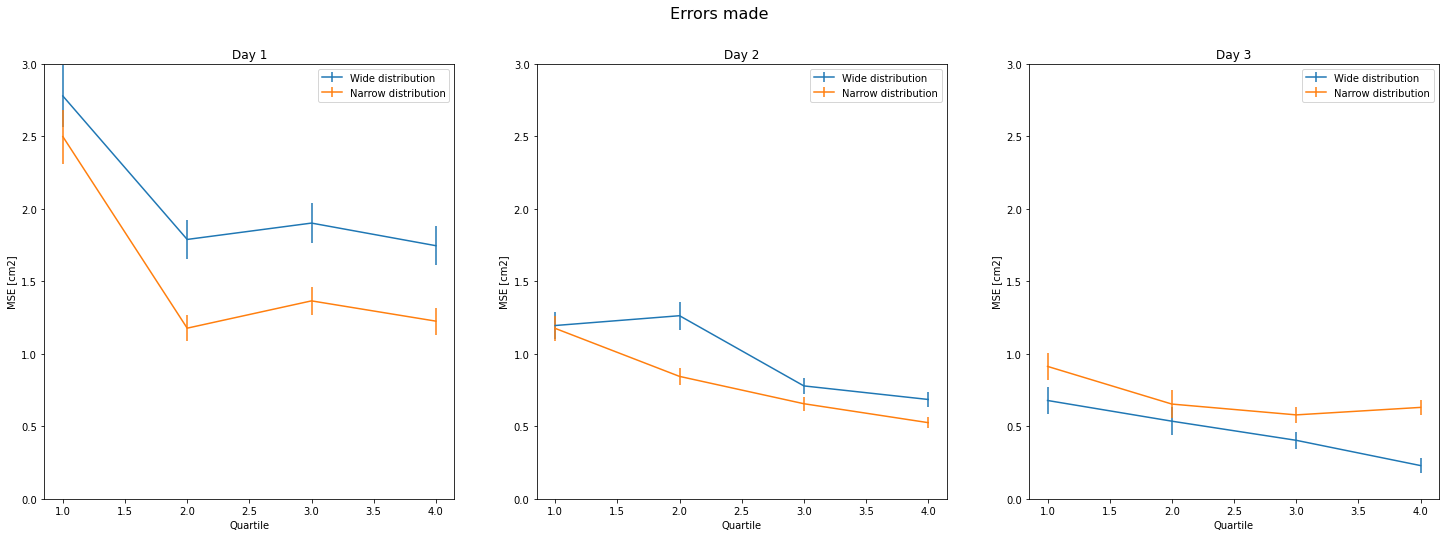

In [ ]:
printmd('*Graph 2B : Mean squarred error of the estimated force plotted against time* \n')
#to plot these graphs, the MSE will be plotted separatly for both groups of subjects over the three days.

"parameters"
quartile = [1, 2, 3, 4]                               


"Data extraction"
#all the necessary matrixes already exist in the code part for the 2C graph.


"Data manipulation : Group 1 (subjects 1-6)"
#day 1
MSE1=(matrice_Y1)**2                                  #delta_y already contains the error, so to obtain the MSE we only had to take the square
matrice_MSE1_split_avgall = np.zeros(4)               #creation of an empty array of length 4 to divide the MSE data into 4 quartiles

for l in range(6):                                    #loop to compute the MSE means over all the subjects
  splitMSE1 = np.array_split(MSE1[l], 4)              #splits the MSE array into 4 equal intervals
  matrice_MSE1_split_avgall += np.array([np.mean(arr) for arr in splitMSE1]) #computes the mean MSE over each interval and sums the corresponding intervals for each subject
matrice_MSE1fini =  matrice_MSE1_split_avgall/6       #division by 6 for the 6 subjects to obtain the mean MSEs


#day2: same operations as for day 1
MSE12=(matrice_Y12)**2
matrice_MSE12_split_avgall = np.zeros(4)

for l in range(6):
  splitMSE12 = np.array_split(MSE12[l], 4) 
  matrice_MSE12_split_avgall += np.array([np.mean(arr) for arr in splitMSE12]) 
matrice_MSE12fini =  matrice_MSE12_split_avgall/6


#day3: same operations as for day 1
MSE13=(matrice_Y13)**2
matrice_MSE13_split_avgall = np.zeros(4)

for l in range(6):
  splitMSE13 = np.array_split(MSE13[l], 4) 
  matrice_MSE13_split_avgall += np.array([np.mean(arr) for arr in splitMSE13]) 
matrice_MSE13fini =  matrice_MSE13_split_avgall/6 


"Data manipulation : Group 2 (subjects 7-11)"
#day1
MSE2=(matrice_Y2)**2
matrice_MSE2_split_avgall = np.zeros(4)

for l in range(5):
  splitMSE2 = np.array_split(MSE2[l], 4) 
  matrice_MSE2_split_avgall += np.array([np.mean(arr) for arr in splitMSE2]) 
matrice_MSE2fini =  matrice_MSE2_split_avgall/5       #division by 5 for the 5 subjects to obtain the mean MSEs


#day2: same operations as for day 1
MSE22=(matrice_Y22)**2
matrice_MSE22_split_avgall = np.zeros(4)

for l in range(5):
  splitMSE22 = np.array_split(MSE22[l], 4) 
  matrice_MSE22_split_avgall += np.array([np.mean(arr) for arr in splitMSE22]) 
matrice_MSE22fini =  matrice_MSE22_split_avgall/5


#day3: same oparations as for day 1
MSE23=(matrice_Y23)**2
matrice_MSE23_split_avgall = np.zeros(4)

for l in range(5):
  splitMSE23 = np.array_split(MSE23[l], 4) 
  matrice_MSE23_split_avgall += np.array([np.mean(arr) for arr in splitMSE23]) 
matrice_MSE23fini =  matrice_MSE23_split_avgall/5


"Computation of the standard deviations to plot the error bars"
matrice_MSE1_split_sdall = np.zeros(4) 
for l in range(6):                                    #loop to compute the MSE standard deviation over all the subjects
  splitMSE1 = np.array_split(MSE1[l], 4)              #splits the MSE array into 4 equal intervals
  matrice_MSE1_split_sdall += np.array([np.std(arr) for arr in splitMSE1]) #computes the ssd MSE over each interval and sums the corresponding intervals for each subject
matrice_MSE1ssd =  (matrice_MSE1_split_sdall/6)/np.sqrt(350)       #division by 6 for the 6 subjects to obtain the ssd MSEs

matrice_MSE12_split_sdall = np.zeros(4) 
for l in range(6):                                    #loop to compute the MSE standard deviation over all the subjects
  splitMSE12 = np.array_split(MSE12[l], 4)            #splits the MSE array into 4 equal intervals
  matrice_MSE12_split_sdall += np.array([np.std(arr) for arr in splitMSE12]) #computes the ssd MSE over each interval and sums the corresponding intervals for each subject
matrice_MSE12ssd =  (matrice_MSE12_split_sdall/6)/np.sqrt(350)       #division by 6 for the 6 subjects to obtain the ssd MSEs

matrice_MSE13_split_sdall = np.zeros(4) 
for l in range(6):                                    #loop to compute the MSE standard deviation over all the subjects
  splitMSE13 = np.array_split(MSE13[l], 4)            #splits the MSE array into 4 equal intervals
  matrice_MSE13_split_sdall += np.array([np.std(arr) for arr in splitMSE13]) #computes the ssd MSE over each interval and sums the corresponding intervals for each subject
matrice_MSE13ssd =  (matrice_MSE13_split_sdall/6)/np.sqrt(350)       #division by 6 for the 6 subjects to obtain the ssd MSEs

matrice_MSE2_split_sdall = np.zeros(4) 
for l in range(5):                                    #loop to compute the MSE standard deviation over all the subjects
  splitMSE2 = np.array_split(MSE2[l], 4)              #splits the MSE array into 4 equal intervals
  matrice_MSE2_split_sdall += np.array([np.std(arr) for arr in splitMSE2]) #computes the ssd MSE over each interval and sums the corresponding intervals for each subject
matrice_MSE2ssd =  (matrice_MSE2_split_sdall/5)/np.sqrt(350)       #division by 5 for the 5 subjects to obtain the ssd MSEs

matrice_MSE22_split_sdall = np.zeros(4) 
for l in range(5):                                    #loop to compute the MSE standard deviation over all the subjects
  splitMSE22 = np.array_split(MSE22[l], 4)            #splits the MSE array into 4 equal intervals
  matrice_MSE22_split_sdall += np.array([np.std(arr) for arr in splitMSE22]) #computes the ssd MSE over each interval and sums the corresponding intervals for each subject
matrice_MSE22ssd =  (matrice_MSE22_split_sdall/5)/np.sqrt(350)       #division by 5 for the 5 subjects to obtain the ssd MSEs

matrice_MSE23_split_sdall = np.zeros(4) 
for l in range(5):                                    #loop to compute the MSE standard deviation over all the subjects
  splitMSE23 = np.array_split(MSE23[l], 4)            #splits the MSE array into 4 equal intervals
  matrice_MSE23_split_sdall += np.array([np.std(arr) for arr in splitMSE23]) #computes the ssd MSE over each interval and sums the corresponding intervals for each subject
matrice_MSE23ssd =  (matrice_MSE23_split_sdall/5)/np.sqrt(350)       #division by 5 for the 5 subjects to obtain the ssd MSEs


"Graph plots"
fig = plt.figure(1,figsize=(25,8))
fig.suptitle('Errors made', fontsize=16)

ax1=fig.add_subplot(1,3,1)
ax2=fig.add_subplot(1,3,2)
ax3=fig.add_subplot(1,3,3)

ax1.set_title("Day 1")
ax1.set_ylabel('MSE [cm2]')
ax1.set_xlabel('Quartile')
ax1.set_ylim(0,3)
ax1.errorbar(quartile, matrice_MSE1fini, yerr = matrice_MSE1ssd, label='Wide distribution')
ax1.errorbar(quartile, matrice_MSE2fini, yerr = matrice_MSE2ssd, label='Narrow distribution')
ax1.legend()

ax2.set_title("Day 2")
ax2.set_ylabel('MSE [cm2]')
ax2.set_xlabel('Quartile')
ax2.set_ylim(0,3)
ax2.errorbar(quartile, matrice_MSE12fini, yerr = matrice_MSE12ssd, label='Wide distribution')
ax2.errorbar(quartile, matrice_MSE22fini, yerr = matrice_MSE22ssd, label='Narrow distribution')
ax2.legend()

ax3.set_title("Day 3")
ax3.set_ylabel('MSE [cm2]')
ax3.set_xlabel('Quartile')
ax3.set_ylim(0,3)
ax3.errorbar(quartile, matrice_MSE13fini, yerr = matrice_MSE12ssd, label='Wide distribution')
ax3.errorbar(quartile, matrice_MSE23fini, yerr = matrice_MSE12ssd, label='Narrow distribution')
ax3.legend()
plt.show()

*Graph 2D : average slope of the curves shown in C  plotted as a function of the day* 


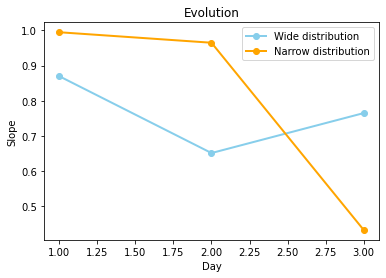

In [ ]:
printmd('*Graph 2D : average slope of the curves shown in C  plotted as a function of the day* \n')

"parameters"
days = [1, 2, 3]                                              #array for the x axis


"Data manipulation: computation of the slopes - day 1"
#group 1
model11 = LinearRegression().fit(np.array(matrice_Ftrue1fini).reshape(-1,1), np.array(DeltaF10).reshape(-1,1)) #function to compute the linear regression
slope11 =model11.coef_                                        #grives the slope of the linear regression

#group 2
model21 = LinearRegression().fit(np.array(matrice_Ftrue2fini).reshape(-1,1), np.array(DeltaF20).reshape(-1,1)) 
slope21 = model21.coef_

"Data manipulation: computation of the slopes - day 2"
#group 1
model12 = LinearRegression().fit(np.array(matrice_Ftrue12fini).reshape(-1,1), np.array(DeltaF102).reshape(-1,1)) 
slope12 =model12.coef_

#group 2
model22 = LinearRegression().fit(np.array(matrice_Ftrue22fini).reshape(-1,1), np.array(DeltaF202).reshape(-1,1)) 
slope22 = model22.coef_

"Data manipulation: computation of the slopes - day 3"
#group 1
model13 = LinearRegression().fit(np.array(matrice_Ftrue13fini).reshape(-1,1), np.array(DeltaF103).reshape(-1,1)) 
slope13 =model13.coef_

#group 2
model23 = LinearRegression().fit(np.array(matrice_Ftrue23fini).reshape(-1,1), np.array(DeltaF203).reshape(-1,1)) 
slope23 = model23.coef_

evolution1 = [slope11[0][0], slope12[0][0], slope13[0][0]]    #creation of an array containing the slopes for the 3 days for group 1 (extraction of values in double array in slope11,..)
evolution2 = [slope21[0][0], slope22[0][0], slope23[0][0]]    #creation of an array containing the slopes for the 3 days for group 2


"Graph plot"
plt.title("Evolution")
plt.xlabel('Day')
plt.ylabel('Slope')
plt.plot(days, evolution1, color='skyblue', label='Wide distribution', linestyle = '-', linewidth = 2, marker = 'o', markerfacecolor = 'skyblue', markersize=6)
plt.plot(days, evolution2, color='orange', label='Narrow distribution', linestyle = '-', linewidth = 2, marker = 'o', markerfacecolor = 'orange', markersize=6)
plt.legend()
plt.show()

**Graph 2E: Average bias when estimating the force in function of the true force for 2 different subjects for day 2** 


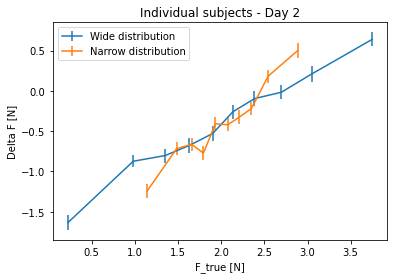

In [ ]:
printmd('**Graph 2E: Average bias when estimating the force in function of the true force for 2 different subjects for day 2** \n')

#For this graph, we will take one subject that started with a wide distribution (subject 1) and on subject that started with a narrow distribution (subject 2).

"Data extraction"
#subject 1
pert2 = Dict['Sujet 1']['F_pert'][1]                      #extraction of the data for F_pert for the second day of subject 1
deltay2 = Dict['Sujet 1']['delta_y'][1]                   #extraction of the data for delta_y for the second day of subject 1
ftrue2 = Dict['Sujet 1']['F_true'][1]                     #extraction of the data for F_true for the second day of subject 1

#subject 7
pert2bis = Dict['Sujet 7']['F_pert'][1]                   #extraction of the data for F_pert for the second day of subject 1
deltay2bis = Dict['Sujet 7']['delta_y'][1]                #extraction of the data for delta_y for the second day of subject 1
ftrue2bis = Dict['Sujet 7']['F_true'][1]                  #extraction of the data for F_true for the second day of subject 1


"Data manipulation: sort the data"
#subject 1
sortftrue20 = np.argsort(ftrue2)                          #returns the indexes for F_true values by ascending order
deltaysort2 = np.zeros(len(deltay2))                      #creation of empty array to sort delta_y according to F_true
sortfpert2 = np.zeros(len(deltay2))                       #creation of empty array to sort F_pert according to F_true

for i in range(len(deltaysort2)):                         #loop to fill the arrays with the corresponding values of delta_y and F_pert of subject 1
  deltaysort2[i] = deltay2[sortftrue20[i]]                #fills the array with the right valus of delta_y
  sortfpert2[i] = pert2[sortftrue20[i]]                   #fills the array with the right valus of F_pert

#subject 7
sortftrue20bis = np.argsort(ftrue2bis)                    #returns the indexes for F_true values by ascending order
deltaysort2bis = np.zeros(len(deltay2))                   #creation of empty array to sort delta_y according to F_true
sortfpert2bis = np.zeros(len(deltay2))                    #creation of empty array to sort F_pert according to F_true

for i in range(len(deltaysort2)):                         #loop to fill the arrays with the corresponding values of delta_y and F_pert of subject 7
  deltaysort2bis[i] = deltay2bis[sortftrue20bis[i]]       #fills the array with the right valus of delta_y
  sortfpert2bis[i] = pert2bis[sortftrue20bis[i]]          #fills the array with the right valus of F_pert


"Data manipulation: splitting of the arrays into 10 equal intervals and computing the mean values"
#subject 1
splitsdeltay2 = np.array_split(deltaysort2, 10)           #splits the delta_y array into 10 intervals
deltay2_split_avg = [np.mean(arr) for arr in splitsdeltay2] #creates an array containing the 10 mean values for the delta_y of each interval

splitsfpert2 = np.array_split(sortfpert2, 10)             #splits the F_pert array into 10 intervals
fpert2_split_avg = [np.mean(arr) for arr in splitsfpert2] #creates an array containing the 10 mean values for the F_pert of each interval

sortftrue2 = np.sort(ftrue2)                              #sorts the F_true data by ascending order
splitssortftrue2 = np.array_split(sortftrue2, 10)         #splits the F_true array into 10 intervals
ftrue2_split_avg = [np.mean(arr) for arr in splitssortftrue2] #creates an array containing the 10 mean values for the F_true of each interval


#subject 7
splitsdeltay2bis = np.array_split(deltaysort2bis, 10)     #splits the delta_y array into 10 intervals
deltay2bis_split_avg = [np.mean(arr) for arr in splitsdeltay2bis] #creates an array containing the 10 mean values for the delta_y of each interval

splitsfpert2bis = np.array_split(sortfpert2bis, 10)       #splits the F_pert array into 10 intervals
fpert2bis_split_avg = [np.mean(arr) for arr in splitsfpert2bis] #creates an array containing the 10 mean values for the F_pert of each interval

sortftrue2bis = np.sort(ftrue2bis)                        #sorts the F_true data by ascending order
splitssortftrue2bis = np.array_split(sortftrue2bis, 10)   #splits the F_true array into 10 intervals
ftrue2bis_split_avg = [np.mean(arr) for arr in splitssortftrue2bis] #creates an array containing the 10 mean values for the F_true of each interval


"Computation of F_estimated and delta_F for each subject"
#subject1
fest2 = np.array(ftrue2_split_avg) + np.array(fpert2_split_avg) - np.array(deltay2_split_avg)/c #F_est = F_true + F_pert - (delta_y)/c
deltaf2 = np.array(ftrue2_split_avg) - fest2              #delta_F = F_true - F_est

#subject7
fest2bis = np.array(ftrue2bis_split_avg) + np.array(fpert2bis_split_avg) - np.array(deltay2bis_split_avg)/c #F_est = F_true + F_pert - (delta_y)/c
deltaf2bis = np.array(ftrue2bis_split_avg) - fest2bis     #delta_F = F_true - F_est

"Computation of the standard deviations to plot the error bars"
#subject1
std_dev_ftrue2 = [np.std(arr) for arr in splitssortftrue2]/np.sqrt(len(deltay1ok)/10) #creates an array containing the standard deviations of delta_y for each interval
std_dev_fpert2 = [np.std(arr) for arr in splitsfpert2]/np.sqrt(len(deltay1ok)/10) #creates an array containing the standard deviations of delta_y for each interval
std_dev_deltay2 = [np.std(arr) for arr in splitsdeltay2]/np.sqrt(len(deltay1ok)/10) #creates an array containing the standard deviations of delta_y for each interval

#subject7
std_dev_ftrue2bis = [np.std(arr) for arr in splitssortftrue2bis]/np.sqrt(len(deltay1ok)/10) #creates an array containing the standard deviations of delta_y for each interval
std_dev_fpert2bis = [np.std(arr) for arr in splitsfpert2bis]/np.sqrt(len(deltay1ok)/10) #creates an array containing the standard deviations of delta_y for each interval
std_dev_deltay2bis = [np.std(arr) for arr in splitsdeltay2bis]/np.sqrt(len(deltay1ok)/10) #creates an array containing the standard deviations of delta_y for each interval

#standard deviations subject 1
std_dev_fest2 = std_dev_ftrue2 + std_dev_fpert2 - std_dev_deltay2/c 
std_dev_deltaf2 = std_dev_ftrue2 - std_dev_fest2

#standard deviations subject 7
std_dev_fest2bis = std_dev_ftrue2bis + std_dev_fpert2bis - std_dev_deltay2bis/c 
std_dev_deltaf2bis = std_dev_ftrue2bis - std_dev_fest2bis

"Graph plot"
plt.title("Individual subjects - Day 2")
plt.xlabel('F_true [N]')
plt.ylabel('Delta F [N]')
plt.errorbar(ftrue2_split_avg, deltaf2, yerr=std_dev_deltaf2, label='Wide distribution')
plt.errorbar(ftrue2bis_split_avg, deltaf2bis, yerr=std_dev_deltaf2bis, label='Narrow distribution')
plt.legend()
plt.show()

**Graph 2F: Endpoint error as a function of the true force averaged over subjects** 


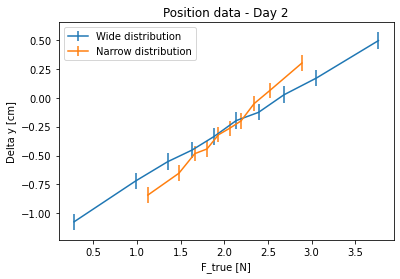

In [ ]:
printmd('**Graph 2F: Endpoint error as a function of the true force averaged over subjects** \n')

#for this graph, all the necessary data has already been computed and is contained in the F_true and delta_Y matrices of all subjects for day 2.

"Computation of the standard deviations to plot the error bars"

matrice_Y12_ssd = np.zeros(10)
for l in range(6):
  splitssdY12 = np.array_split(matrice_Y12sort[l], 10) 
  matrice_Y12_ssd += np.array([np.std(arr) for arr in splitssdY12]) 
ssdmatrice_Y12 = (matrice_Y12_ssd/6)/np.sqrt(len(deltay1ok)/10)

matrice_Y22_ssd = np.zeros(10)
for l in range(5):
  splitssdY22 = np.array_split(matrice_Y22sort[l], 10) 
  matrice_Y22_ssd += np.array([np.std(arr) for arr in splitssdY22]) 
ssdmatrice_Y22 = (matrice_Y22_ssd/5)/np.sqrt(len(deltay1ok)/10)

"Graph plot"
plt.title("Position data - Day 2")
plt.xlabel('F_true [N]')
plt.ylabel('Delta y [cm]')
plt.errorbar(matrice_Ftrue12fini, matrice_Y12fini, yerr = ssdmatrice_Y12, label='Wide distribution')
plt.errorbar(matrice_Ftrue22fini, matrice_Y22fini, yerr = ssdmatrice_Y22, label='Narrow distribution')
#plt.plot(matrice_Ftrue12fini, matrice_Y12fini, color='skyblue', label='Wide distribution', linestyle = 'dashed', linewidth = 2, marker = 'o', markerfacecolor = 'skyblue', markersize=6)
#plt.plot(matrice_Ftrue22fini, matrice_Y22fini, color='orange', label='Wide distribution', linestyle = 'dashed', linewidth = 2, marker = 'o', markerfacecolor = 'orange', markersize=6)
plt.legend()
plt.show()

**Why is prior knowledge important in general ? How does it help (or not)  reducing the errors in this task ?**

The prior knowledge appears in the formula of the Bayes theorem:

P(y|x) = (P(x|y)*P(y))/P(x)

where P(y|x) is the posterior, P(x|y) is the likelihood, P(y) is the prior and P(x) is the normalization term.

This theorem allows to determine the probability that an event occurs on the basis of an other event that already happened. During this project and the practical sessions, we noticed that the prior carried out an important influence on the posterior when it is very informatif. 

Here in this experiment, the prior was very informative in the case of the subjects starting with the narrow distribution (0.5N). We saw that they relied more on the prior than subjects starting with the wide distribution. Indeed, we can see that the slope is steeper for the narrow distributions. This is due to the fact that they rely more on prior knowledge than on the sensory feedback and thus have more difficulty to adapt to the range of forces, meaning the errors are more important. 

Another observation is that, between the wide and narrow distributions, there was no big differences the first day. However, the differences became more important on the second day. This is due to the reliance difference on the prior, since the wide distribution subjects adapt more easily as they relied more on the feedback.

In conclusion, depending on their different priors, the subjects tuned their performances. In some cases, the prior can be very helpfull to predict values closer to reality, but in this case it induced bigger errors for the participants relying mostly on the prior.








**What is the research question and why is the task suitable to answer it ?**

The goal of this study is to examine if the central nervous system uses Bayesian models when estimating force requirements.  It was already shown that this is the case for visual tasks, but they wanted to know if it was limited to that or not. 

The task was to estimate the optimal force knowing that the subjects had an extensive training beforehand and that sensory feedback from the initial part of each trial could be used to determine the appropriate forces to apply on the second half of the trial. 

This task is suitable to answer to this question because one of the most important terms in the Bayesian model is the prior. Here, the subjects had a first training experience where they could get used to the task, acquire experience and gather knowledge about the task. By performing the same experiences with different force values after that, it is possible to see if the prior experience influenced the behaviors of the subjects or not, namely how much they rely on previous knowledge. This whole experiment allows researchers to study if and how the subjects integrate information thanks to their prior experience to generate force estimations. This thus allows to study whether the CNS uses the Bayesian model to estimate forces or not. 


**Explain with your own words how each graphs of figure 2A are obtained. In particular, explain why we expect a linear relationship between dF and F_true if we use full bayesian strategies ? What does the slope represent ?**

For the "*full bayesian*" and the "*one prior"* graphs, we can see that the errors are very small or even zero around 2N as this is the mean of both distributions (narrow and wide). Consequently, the subjects are more familiar with these forces and can estimate correctly. On the other hand, when the forces diverge from 2N, the error becomes more important when we move away from the mean of the distribution (2N). When the forces become smaller than 2N, subjects under-estimate the forces and above 2N they over-estimate the forces (this is the case for both distributions). The relationship between dF and F is linear because we assume that the subjects always over- or under-estimate in the same way. 


The slope represents how much the errors vary with the forces. Therefore, the slope indicates how much the subjects under- or over-estimate the forces.  


The 3 graphs on figure 2A are predictions from the three computational models which are:

-	Naive compensation: subjects ignore the prior distribution and compensate for the perceived force by feedback. The force estimation error is thus always zero since they compensate exactly.

-	Full Bayesian: we can see that the slopes are different depending on the distributions. The slope for the narrow distribution is steeper than for the wide distribution. This is a consequence of the fact that the prior is more informative for the narrow distribution. In consequence, the subjects of that groupe tend to base their estimations more on the prior and they rely less on sensory feedback. On the other hand, the subjects with the wide distributions rely more on feedback and thus their errors are smaller.

-	One prior only: we can see that the two curves (wide and narrow distributions) are overlapping. This is due to the fact that the subjects only use one prior (that is either genetically predefined or acquired). In consequence, they rely on exactly the same prior knowledge and thus the slope is the same for both groups of subjects, i.e. the slope doesn't depend on the distribution. 
